In [3]:

import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Read in and EDA

In [4]:

#Read the csv file
df = pd.read_csv('henry_csv_17-23.csv')#, infer_datetime_format= True)
renames = {'00065': 'Gage Height', '00060': 'Discharge', '72254': 'Velocity'}
df = df.rename(columns = renames)

df = df[['datetime', 'Discharge', 'Gage Height', 'Velocity']]
df = df.set_index('datetime')
df.dropna(axis = 0, inplace = True)

print(df.head()) #3 columns

                           Discharge  Gage Height  Velocity
datetime                                                   
2017-01-01 00:00:00-06:00    20400.0        16.95      2.45
2017-01-01 00:15:00-06:00    19800.0        16.96      2.37
2017-01-01 00:30:00-06:00    20900.0        16.98      2.51
2017-01-01 00:45:00-06:00    19300.0        16.95      2.32
2017-01-01 01:00:00-06:00    20700.0        16.98      2.49


C:\Users\perso\AppData\Local\Temp\ipykernel_8420\3248726592.py:2: DtypeWarning: Columns (2,5,11,13,15,17,19,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('henry_csv_17-23.csv')#, infer_datetime_format= True)


In [5]:
#Separate dates for future plotting
train_dates = df.index.to_series()
print(train_dates.tail(15)) #Check last few dates.

datetime
2022-12-01 20:15:00-06:00    2022-12-01 20:15:00-06:00
2022-12-01 20:30:00-06:00    2022-12-01 20:30:00-06:00
2022-12-01 20:45:00-06:00    2022-12-01 20:45:00-06:00
2022-12-01 21:00:00-06:00    2022-12-01 21:00:00-06:00
2022-12-01 21:15:00-06:00    2022-12-01 21:15:00-06:00
2022-12-01 21:30:00-06:00    2022-12-01 21:30:00-06:00
2022-12-01 21:45:00-06:00    2022-12-01 21:45:00-06:00
2022-12-01 22:00:00-06:00    2022-12-01 22:00:00-06:00
2022-12-01 22:15:00-06:00    2022-12-01 22:15:00-06:00
2022-12-01 22:30:00-06:00    2022-12-01 22:30:00-06:00
2022-12-01 22:45:00-06:00    2022-12-01 22:45:00-06:00
2022-12-01 23:00:00-06:00    2022-12-01 23:00:00-06:00
2022-12-01 23:15:00-06:00    2022-12-01 23:15:00-06:00
2022-12-01 23:30:00-06:00    2022-12-01 23:30:00-06:00
2022-12-01 23:45:00-06:00    2022-12-01 23:45:00-06:00
Name: datetime, dtype: object


In [6]:
# Subset the train/testing data
# Train: 2017-2018, 2020
# Test: 2019, 2021

train = df['2020':'2021'] # 2020-2021
test = df['2021':'2022'] # Year of 2022

In [7]:
trainx_prescale = train.drop("Discharge", axis= 1)

## Data manipulation

In [8]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset

scaler = StandardScaler()
scaler = scaler.fit(train)
train_scaled = scaler.transform(train)


scaler_X = scaler.fit(trainx_prescale)
trainx_prescale = scaler.transform(trainx_prescale)

In [9]:
trainx_prescale

array([[-0.01233026,  1.34950998],
       [-0.02334606,  1.1214551 ],
       [-0.01783816,  1.28435144],
       ...,
       [-0.75314321, -0.72470352],
       [-0.73386555, -0.92017913],
       [-0.74763531, -0.75728279]])

In [10]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.
#In this example, the n_features is 3. We will make timesteps = 672 (past 7 days data used for training).

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

time_to_hr = 4 # 4 timesteps per hour
time_to_day = time_to_hr * 24 # 24hrs in a day

n_future = 12 # Number of timesteps we want to look into the future based on the past timesteps. 4 * 3hrs = 12
n_past = 3 * time_to_day # Number of past timesteps we want to use to predict the future. 7 days x 24hrs x 4 timesteps/hr = 672

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).

for i in range(n_past, len(train_scaled) - n_future +1):
    trainX.append(trainx_prescale[i - n_past:i, 0:train_scaled.shape[1]])
    trainY.append(train_scaled[i + n_future - 1:i + n_future, 0]) # 0 = Discharge

trainX, trainY = np.array(trainX), np.array(trainY)


print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (33705, 288, 2).
trainY shape == (33705, 1).


## Model Dev

In [239]:
# If possible, try to load the model, if it doesn't work, retrain
"""try:
    model_lstm = tf.keras.models.load_model('./saved_model/LSTM_Saved_Mikey_1')
except:"""

    #In my case, trainX has a shape (100301, 672, 3).

    #100301 because we are looking back 672 timesteps ##(12823 - 14 = 12809).
    #Remember that we cannot look back 12 timesteps until we get to the 13th timesteps.

    #Also, trainY has a shape (100301, 1). Our model only predicts a single value, but
    #it needs multiple variables (5 in my example) to make this prediction.
    #This is why we can only predict a single day after our training, the day after where our data ends.
    #To predict more days in future, we need all the 5 variables which we do not have.
    #We need to predict all variables if we want to do that.

    # define the Autoencoder model

#'''
# The LSTM architecture -- Basic RNN | one layer then dense
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(trainX.shape[1], trainX.shape[2])))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 125)               64000     
                                                                 
 dense_4 (Dense)             (None, 1)                 126       
                                                                 
Total params: 64,126
Trainable params: 64,126
Non-trainable params: 0
_________________________________________________________________


In [240]:
batch_size = 16

model_lstm.fit(trainX, trainY, epochs=5, batch_size=batch_size, verbose=1)


Epoch 1/10
2107/2107 [==============================] - 244s 114ms/step - loss: 0.0200
Epoch 2/10
2107/2107 [==============================] - 316s 150ms/step - loss: 0.0125
Epoch 3/10
2107/2107 [==============================] - 270s 128ms/step - loss: 0.0116
Epoch 4/10
2107/2107 [==============================] - 244s 116ms/step - loss: 0.0107
Epoch 5/10
2107/2107 [==============================] - 287s 136ms/step - loss: 0.0098
Epoch 6/10
2107/2107 [==============================] - 263s 125ms/step - loss: 0.0096
Epoch 7/10
2107/2107 [==============================] - 232s 110ms/step - loss: 0.0093
Epoch 8/10
2107/2107 [==============================] - 256s 122ms/step - loss: 0.0091
Epoch 9/10
2107/2107 [==============================] - 237s 112ms/step - loss: 0.0088
Epoch 10/10
2107/2107 [==============================] - 226s 107ms/step - loss: 0.0086


In [ ]:
'''
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

# fit the model
history = model.fit(trainX, trainY, epochs=1, batch_size=16, validation_split=0.1, verbose=1)
'''
""" plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()"""
'''
#Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/LSTM_Saved_Mikey_1')
#'''
## Predictions

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 64)           17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


Exception ignored in: <function UniquePtr.__del__ at 0x000002664CBCB8B0>
Traceback (most recent call last):
  File "C:\Users\perso\anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
KeyboardInterrupt: 


1046/7551 [===>..........................] - ETA: 1:18:09 - loss: nan

In [13]:
model_lstm = tf.keras.models.load_model('./saved_model/LSTM_Saved_Mikey_1')


### Transform the test data

In [14]:
testX = []
testY = []

n_future = 12 # Number of timesteps we want to look into the future based on the past timesteps. 4 * 3hrs = 12
n_past = 3 * time_to_day

scaler2 = StandardScaler()
scaler2 = scaler2.fit(test)
test_scaled = scaler2.transform(test)

for i in range(n_past, len(test_scaled) - n_future +1):
    testX.append(test_scaled[i - n_past:i, 0:test_scaled.shape[1]])
    testY.append(test_scaled[i + n_future - 1:i + n_future, 0]) # 0 = Discharge

testX, testY = np.array(testX), np.array(testY)

#Make prediction
# Will only use the last 7 days of the training data to predict X number of days into the testing data
prediction = model_lstm.predict(testX, verbose = 1)


ValueError: in user code:

    File "C:\Users\perso\anaconda3\envs\MeselheResearch\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\perso\anaconda3\envs\MeselheResearch\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\perso\anaconda3\envs\MeselheResearch\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\perso\anaconda3\envs\MeselheResearch\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\perso\anaconda3\envs\MeselheResearch\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\perso\anaconda3\envs\MeselheResearch\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 672, 3), found shape=(None, 288, 3)


In [ ]:

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform


prediction_copies = np.repeat(prediction, test.shape[1], axis=-1)
y_pred = scaler2.inverse_transform(prediction_copies)[:, 0]  # Location of Discharge in columns

test_predicts = test[:-n_past -11].copy()
test_predicts["Predicted Discharge"] = y_pred
test_predicts.rename(columns= {-1 : "Predicted Discharge"})
#test_predicts = test_predicts.drop("Dis", axis=1)

NameError: name 'test_predicts' is not defined

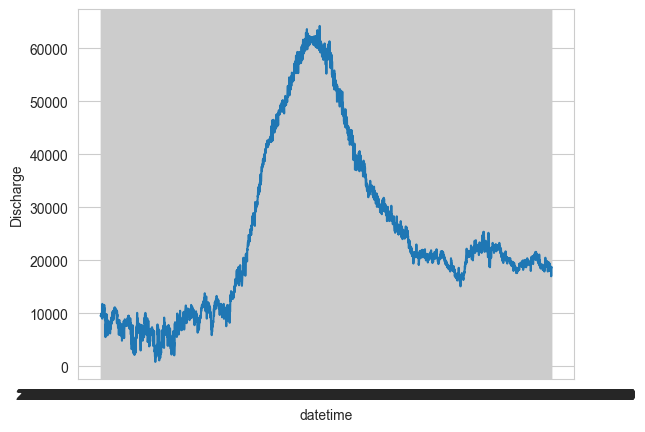

In [15]:

import seaborn as sns
tstart = '2021-06-15'
tend = '2021-07-20'

sns.lineplot(test['Discharge'][tstart : tend], errorbar= None)
sns.lineplot(test_predicts["Predicted Discharge"][tstart : tend].shift(n_past), errorbar= None)
# shifting 7 to overlay due to inherent shifting from original formatting of the data.



In [ ]:

sns.lineplot(test['Discharge'], errorbar= None)
sns.lineplot(test_predicts["Predicted Discharge"].shift(n_past), errorbar= None)
# shifting 7 to overlay due to inherent shifting from original formatting of the data.


In [ ]:
test_predicts

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error


In [ ]:
mean_squared_log_error(test['Discharge'][:-n_past-11], test_predicts["Predicted Discharge"])


In [208]:
mean_squared_error(test['Discharge'][:-n_past-11], test_predicts["Predicted Discharge"])


43040621.407637045

In [209]:
r2_score(test['Discharge'][:-n_past-11], test_predicts["Predicted Discharge"])


0.5947433491065697

## Future Predictions


In [148]:
# Run test
# Prediction
#pred_WL = model_lstm.predict(testX)
n_future_pred = 3 * time_to_hr
overlap = 1
pred_WL = model_lstm.predict(testX[-n_future_pred - overlap:])

predict_period_dates = pd.date_range(list(test.index)[-(overlap)],periods=n_future_pred + overlap, freq='15min').tolist()

1/1 [==============================] - 0s 79ms/step


In [150]:
pred_WL

array([[-0.1602038 ],
       [-0.15829103],
       [-0.1553822 ],
       [-0.15555653],
       [-0.15500872],
       [-0.1539407 ],
       [-0.14966014],
       [-0.15071718],
       [-0.1513566 ],
       [-0.15544336],
       [-0.15271717],
       [-0.15169932],
       [-0.14429007]], dtype=float32)

In [146]:
'''
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
len(y_pred_future)
'''
df_forecast = pd.DataFrame({'Date': pd.to_datetime(predict_period_dates),
                            'Gage Height':pred_WL})

ValueError: Per-column arrays must each be 1-dimensional

In [88]:
df_forecast.set_index('Date', inplace= True)

In [89]:
original = df[['Gage Height']]
original = original.loc['2021-12-25': '2022']

In [90]:
original

,Gage Height
datetime,
2021-12-25 00:00:00-06:00,15.47
2021-12-25 00:15:00-06:00,15.49
2021-12-25 00:30:00-06:00,15.50
2021-12-25 00:45:00-06:00,15.46
2021-12-25 01:00:00-06:00,15.51
...,...
2021-12-31 22:45:00-06:00,16.00
2021-12-31 23:00:00-06:00,16.01
2021-12-31 23:15:00-06:00,16.01


<Axes: xlabel='datetime'>

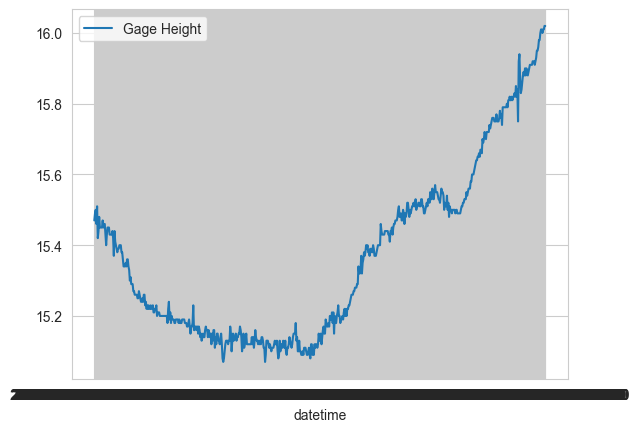

In [91]:
sns.lineplot(original, errorbar= None)

<Axes: xlabel='Date'>

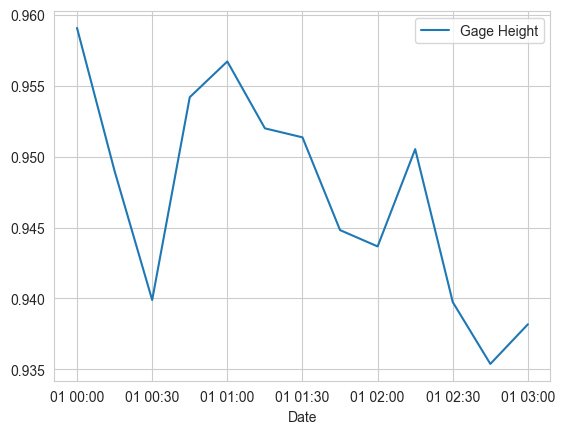

In [92]:
sns.lineplot(df_forecast,errorbar= None)


In [93]:
df_forecast

,Gage Height
Date,
2022-12-01 00:00:00-06:00,0.959061
2022-12-01 00:15:00-06:00,0.948979
2022-12-01 00:30:00-06:00,0.939894
2022-12-01 00:45:00-06:00,0.954180
2022-12-01 01:00:00-06:00,0.956698
2022-12-01 01:15:00-06:00,0.951986
2022-12-01 01:30:00-06:00,0.951351
2022-12-01 01:45:00-06:00,0.944818
2022-12-01 02:00:00-06:00,0.943667


In [ ]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])
